In [1]:
import random
import math
import csv
import numpy as np
import pandas as pd
from pprint import pprint
import os

import matplotlib.pyplot as plt
from IPython.display import clear_output, display

nPreamble = 54        # Number of preambles
nGrantUL = 12         # Number of UL Grant

maxRarWindow = 4
accessTime = 5

In [2]:
from datetime import datetime

# 현재 날짜와 시간을 가져옵니다.
now = datetime.now()

# 날짜와 시간을 'YYYYMMDDHHMMSS' 형식으로 출력합니다.
formatted_date_time = now.strftime('%Y%m%d%H%M')
print(formatted_date_time)

import tensorflow as tf

if not os.path.exists(formatted_date_time):
    os.makedirs(formatted_date_time)

log_dir = formatted_date_time + "/q-learning/"
if not os.path.exists(log_dir):
    os.makedirs(log_dir)
summary_writer = tf.summary.create_file_writer(log_dir)

202401251905


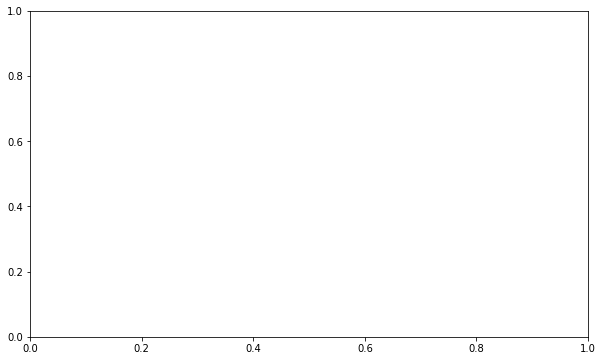

In [3]:
# Plot 초기 설정
plt.ion()
fig, ax = plt.subplots(figsize=(10, 6))
rewards = []

In [4]:
class UserInfo:
    def __init__(self, idx, timer, active, preamble, nTxPreamble, nTxPr,
                 rarWindow, msg1ReTx, msg2, msg2Receive, msg3Tx, msg3Wait, msg3Faile, msg4Process, txTime, nowBackoff, 
                 firstTxTime, secondTxTime, RaFailed, RA, idleTime, numberTx):
        self.idx = idx
        self.timer = timer
        self.active = active
        self.preamble = preamble
        self.nTxPreamble = nTxPreamble
        self.nTxPr = nTxPr
        self.rarWindow = rarWindow
        self.msg1ReTx = msg1ReTx
        self.msg2 = msg2
        self.msg2Receive = msg2Receive
        self.msg3Tx = msg3Tx
        self.msg3Wait = msg3Wait
        self.msg3Faile = msg3Faile
        self.msg4Process = msg4Process
        self.txTime = txTime
        self.nowBackoff = nowBackoff
        self.firstTxTime = firstTxTime
        self.secondTxTime = secondTxTime
        self.RaFailed = RaFailed
        self.RA = RA
        self.idleTime = idleTime
        self.numberTx = numberTx

In [5]:
def activeUE(user, time):
    user.active = 1
    user.preamble = random.randint(0, nPreamble-1)
    user.nTxPreamble = 1
    user.numberTx += 1
    
    user.txTime = time + 1
    tmp = random.randint(0, backoffIndicator-1)
    subTime = user.txTime + tmp

    if subTime % accessTime == 0:
        # 일정 시간 다음에 전송 시도
        user.txTime = subTime + 1
    elif subTime % accessTime == 1:
        # 일정 시간 다음에 전송 시도
        user.txTime = subTime
    else:
        # 일정 시간 다음에 전송 시도
        user.txTime = subTime + (accessTime - (subTime % accessTime) + 1)
        
    user.timer = 0
    user.rarWindow = 0
    user.msg1ReTx = 0
    user.nowBackoff = 0
    user.firstTxTime = time + 1

In [6]:
collision_allocation_probability = 0.676407778464641
def preambleCollisionDetection(user, activeCheck, time, grantCheck):
    user_tx = np.array([(user[i].idx, user[i].RA, user[i].txTime, user[i].msg2, user[i].nowBackoff, user[i].active, user[i].preamble) for i in range(activeCheck) if user[i].RA == 0 and user[i].txTime == time + 1 and user[i].msg2 == 0 and user[i].nowBackoff <= 0 and user[i].active == 1])

    if len(user_tx) > 0:
        preambleTxUEs = user_tx[:, 0].astype(int)
        preambles = np.zeros(nPreamble, dtype=int)
        userCheck = np.zeros((nPreamble, len(preambleTxUEs)), dtype=int)

        for i, ue_idx in enumerate(preambleTxUEs):
            RAPID = user_tx[i, 6]
            userCheck[RAPID, preambles[RAPID]] = ue_idx
            preambles[RAPID] += 1

        for i in range(nPreamble):
            # Allocate resources to single and collided preambles
            if preambles[i] > 0:
                grantCheck += 1
                if grantCheck <= nGrantUL:
                    # Randomly decide whether to allocate resources to collided preambles
                    for j in range(preambles[i]):
                        if preambles[i] == 1 or (preambles[i] > 1 and random.random() < collision_allocation_probability):
                            user[userCheck[i, j]].msg2 = 1

    return grantCheck if grantCheck > 0 else None

In [7]:
def msg2Results(user, time):
    txLimit = 0
    if user.RA == 0:
        if user.msg2 == 0 and user.active == 1:
            user.rarWindow = 5
            user.txTime += 3
            user.numberTx += 1
            if user.rarWindow >= maxRarWindow:
#                 user.preamble = random.randint(0, nPreamble-1)
                user.nTxPr += 14
                user.nTxPreamble += 1
                user.rarWindow = 0
                user.msg1ReTx += 1
                
                oTx = 0
                oTx += user.nTxPr
                oTx += user.msg3Tx
                
                # 에너지 최소화를 위한 제약조건
                if user.idleTime != 0:
                    if user.idleTime > user.nTxPreamble*(oTx/user.idleTime)*(user.numberTx*0.5):
                        backoffRange = user.nTxPreamble * backoffIndicator
                        tmp = random.randint(0, backoffRange-1)
                    else:
                        tmp = random.randint(0, backoffIndicator-1)
                else:
                    tmp = random.randint(0, backoffIndicator-1)
                    
                subTime = user.txTime + tmp

                if subTime % accessTime == 0:
                    # 일정 시간 다음에 전송 시도
                    user.txTime = subTime + 1
                elif subTime % accessTime == 1:
                    # 일정 시간 다음에 전송 시도
                    user.txTime = subTime
                else:
                    # 일정 시간 다음에 전송 시도
                    user.txTime = subTime + (accessTime - (subTime % accessTime) + 1)
                # backoff counter 설정
                user.nowBackoff = user.txTime - time - 1
                user.secondTxTime = user.txTime

                if user.msg1ReTx >= maxMsg1ReTx:
                    user.preamble = random.randint(0, nPreamble-1)
                    user.nTxPreamble = 1
                    user.RaFailed += 1
                    user.rarWindow = 0
                    user.msg1ReTx = 0
                    user.timer = 0
        elif user.msg2 == 1:
            user.numberTx += 1
            user.msg2Receive += 32.5
            user.active = 2
            # MSG 1에 대한 MSG 2수신 성공
            user.txTime += 10
            user.idleTime += 10
            user.secondTxTime = user.txTime
            user.msg3Wait = 0

In [8]:
def resourceRequestAllocation(user, activeCheck, time):
    for i in range(activeCheck):
        if user[i].txTime == time and user[i].msg2 == 1 and user[i].active == 2 and user[i].RA == 0:
            user[i].msg3Tx += 100
            if user[i].msg3Wait <= 48:
                p = random.random()
                user[i].idleTime += 49
                if p > 0.1:
                    user[i].active = 0
                    user[i].RA = 1
                    user[i].timer = user[i].timer + 6
                    user[i].msg4Process += 50
                else:
                    user[i].txTime += 49
                    user[i].msg3Wait = 49
            else:
                user[i].RA = 0
                user[i].RaFailed += 1
                user[i].msg3Faile += 1
                user[i].active = 1
                user[i].msg2 = 0
                user[i].preamble = random.randint(0, nPreamble-1)
                user[i].nTxPr += 14
                
                oTx = 0
                oTx += user[i].nTxPr
                oTx += user[i].msg3Tx

                # 에너지 최소화를 위한 제약조건
                if user[i].idleTime > user[i].nTxPreamble*(oTx/user[i].idleTime)*(user[i].numberTx*0.5):
                    backoffRange = user[i].nTxPreamble * backoffIndicator
                    tmp = random.randint(0, backoffRange-1)
                else:
                    tmp = random.randint(0, backoffIndicator-1)
        
                subTime = user[i].txTime + tmp

                if subTime % accessTime == 0:
                    user[i].txTime = subTime + 1
                elif subTime % accessTime == 1:
                    user[i].txTime = subTime
                else:
                    user[i].txTime = subTime + (accessTime - (subTime % accessTime) + 1)
                user[i].secondTxTime = user[i].txTime
                user[i].nowBackoff = user[i].txTime - time - 1
                user[i].rarWindow = 0
                user[i].nTxPreamble = 1
                user[i].msg1ReTx = 0
                user[i].timer = 0
                user[i].numberTx += 1

In [9]:
def timerIncrease(user):
    user.timer += 1
    
    if user.nowBackoff > 0:
        user.nowBackoff -= 1
        user.idleTime += 1

In [10]:
def successUEs(user, nUE):
    success = 0
    for i in range(nUE):
        if user[i].RA == 1:
            success += 1
    return success

In [11]:
betaF = 0.0165

def betaDist(a, b, x):
    betaValue = (1 / betaF) * (pow(x, (a - 1))) * (pow((1 - x), (b - 1)))
    return betaValue

In [12]:
import time

start = time.time() # 시작
print(f"{time.time()-start:.4f} sec")

0.0000 sec


In [13]:
def normalize_and_average(data):
    # 데이터에서 최소값과 최대값을 가져옵니다.
    min_val = min(data)
    max_val = max(data)

    # 데이터를 정규화합니다.
    normalized_data = [(x - min_val) / (max_val - min_val) for x in data]

    # 정규화된 데이터의 평균을 반환합니다.
    return sum(normalized_data) / len(normalized_data)

In [14]:
def simulation(backoffIndicator):
    start = time.time() # 시작
#     random.seed(1)
    nTxPreambleList = []
    nPreReTx = []
    Logs = [['nUE', 'Success UEs', 'Average Delay', 'Average Energy', 'Average Failed', 'Average Idle Time', 'Average Tx']]
    Congestion = []
    ueTxPreambles = [0 for num in range(100)]
    ueReTx = 0
    UEs = [None] * nUE
    SlotIdle = []
    Congestion = []
    SlotEnergy = []
    SlotTime = []

    for i in range(nUE):
        UEs[i] = UserInfo(i, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)

    activeCheck = 0
    grantCheck = 0

    maxTime = 10000
    nSuccessUE = 0
    totalEnergy = 0

    for intime in range(maxTime):
        nSuccessUE = 0

        if intime % accessTime == 0:
            grantCheck = 0

            numBetaDist = betaDist(3, 4, float(intime) / float(maxTime))
            accessUEs = int(math.ceil(float(nUE) * numBetaDist / (float(maxTime) / float(accessTime))))
            activeCheck += accessUEs

            if activeCheck >= nUE:
                activeCheck = nUE
            
            idleRAO = 0
            activationUE = 0
            slotEnergyConsumption = 0
            for i in range(activeCheck):
                if UEs[i].RA == 0 and UEs[i].active == 0:
                    activeUE(UEs[i], intime)

                if UEs[i].RA == 0 and UEs[i].active != 0:
                    activationUE += 1
                    idleRAO += UEs[i].idleTime
                    slotEnergyConsumption += UEs[i].nTxPr
                    slotEnergyConsumption += UEs[i].msg2Receive
                    slotEnergyConsumption += UEs[i].msg3Tx
                    slotEnergyConsumption += UEs[i].msg4Process

            if activationUE == 0:
                SlotIdle.append(0)
                Congestion.append(0)
                SlotEnergy.append(0)
            else:
                SlotIdle.append(idleRAO/activationUE)
                Congestion.append(activationUE/activeCheck)
                SlotEnergy.append(slotEnergyConsumption/activeCheck)

            preambleCollisionDetection(UEs, activeCheck, intime, grantCheck)

            for i in range(activeCheck):
                if UEs[i].nowBackoff <= 0 and UEs[i].txTime == intime + 1 and UEs[i].active == 1 and UEs[i].RA == 0:
                    msg2Results(UEs[i], intime + 1)

        resourceRequestAllocation(UEs, activeCheck, intime)

        for i in range(activeCheck):
            if UEs[i].active > 0 and UEs[i].RA == 0:
                timerIncrease(UEs[i])

        nSuccessUE = successUEs(UEs, nUE)
        if nSuccessUE == nUE:
            break

    totalSuccess = 0
    totalDelay = 0
    delayList = []
    for i in UEs:
        if i.RA == 1:
            totalSuccess += 1
            totalDelay += i.timer
            delayList.append(i.timer)
        totalEnergy += i.nTxPr
        totalEnergy += i.msg2Receive
        totalEnergy += i.msg3Tx
        totalEnergy += i.msg4Process
        totalEnergy += 100
            
    average_delay = normalize_and_average(delayList)
    
    totalCongestion = 0
    for i in range(len(Congestion)):
        totalCongestion += Congestion[i]
        
    mean_slotEnergy = np.mean(SlotEnergy)/1000
    
    return totalSuccess/nUE, totalCongestion/len(Congestion), average_delay, totalDelay/totalSuccess, totalEnergy/nUE

In [15]:
import math

def log_scale(value, base=10):
    return math.log(value + 1, base)

def ReturnRewards(success_UEs, failed_UEs, energy, delay, backoff, maxTx, congestion):
    # 가중치 설정
    w_success = 0.3
#     w_congestion = 0.1
    w_energy = 0.35
    w_delay = 0.35
    
    # 로그 스케일링
    success_log = log_scale(success_UEs)
    congestion_log = log_scale(congestion)
    energy_log = log_scale(energy)
    delay_log = log_scale(delay)
    
    # 보상 계산
    total_reward = (w_success * success_log - 
#                     w_congestion * congestion_log -
                    w_energy * energy_log - 
                    w_delay * delay_log)
    
    return total_reward

In [16]:
# 강화학습 알고리즘 초기 설정 (예: Q-learning)
Q = {}  # Q-value 초기화
learning_rate = 0.001
discount_factor = 0.99
exploration_rate = 1.0
max_exploration_rate = 1.0
min_exploration_rate = 0.01
exploration_decay_rate = 0.001

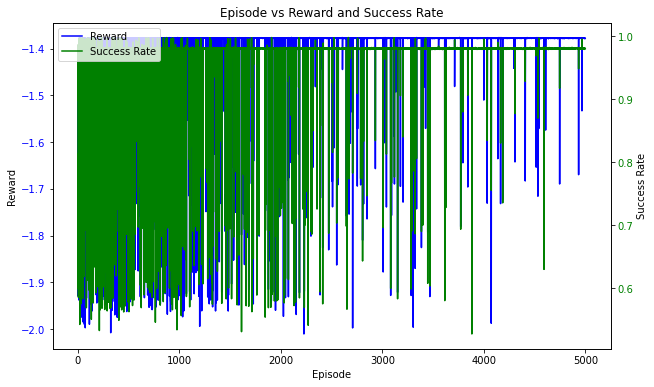

Episode: 4999, BackoffIndicator: 10, maxMsg1ReTx: 2, Reward: -1.3783, Congestion: 0.0830
- Success rate: 0.9806, Average access delay: 35.5318(0.3089)
Optimal backoffIndicator: 10, Optimal maxMsg1ReTx: 2


In [17]:
RewardList = []
rewards = []
success_ratio_list = []
nUE = 50000

maximum_bi = 400
maximum_maxTx = 40

# 학습 반복
for episode in range(5000):
    if episode == 0:
        backoffIndicator = 20
        maxMsg1ReTx = 10
    # 환경에서 액션을 실행하고 새 상태 및 보상을 관찰
    success_ratio, congestion, n_average_delay, average_delay, meanUEEnergy = simulation(backoffIndicator)  # simulation 함수는 외부에서 정의됨
    success_ratio_list.append(success_ratio)
    success_UEs = success_ratio * nUE
    failed_UEs = nUE - success_UEs
    
    # 보상 결정 (이 부분은 조정이 필요)
    reward = ReturnRewards(success_ratio, 1-success_ratio, meanUEEnergy, average_delay, backoffIndicator, maxMsg1ReTx, congestion)
#     reward = success_ratio
    rewards.append(reward)
    
    RewardList.append([reward, success_ratio, congestion, n_average_delay, average_delay, meanUEEnergy, backoffIndicator, maxMsg1ReTx])
    
    # 로깅 및 시각화는 여기서 수행합니다 (이전 코드 참조)
    clear_output(wait=True)  # 현재 셀 출력 클리어
    fig, ax1 = plt.subplots(figsize=(10, 6))

    ax1.set_xlabel("Episode")
    ax1.set_ylabel("Reward")
    ax1.plot(rewards, label='Reward', color='b')
    ax1.tick_params(axis='y', labelcolor='b')

    ax2 = ax1.twinx()
    ax2.set_ylabel("Success Rate")
    ax2.plot(success_ratio_list, label='Success Rate', color='g')
    ax2.tick_params(axis='y', labelcolor='g')

    # Single legend box for both graphs
    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines + lines2, labels + labels2, loc='upper left')

    plt.title("Episode vs Reward and Success Rate")
    plt.show()
    
    print("Episode: {}, BackoffIndicator: {}, maxMsg1ReTx: {}, Reward: {:.04f}, Congestion: {:.04f}".format(episode, backoffIndicator, maxMsg1ReTx, reward, congestion))
    print("- Success rate: {:.04f}, Average access delay: {:.04f}({:.04f})".format(success_ratio, average_delay, n_average_delay))
    
    state_key = (backoffIndicator, maxMsg1ReTx, success_ratio, average_delay, meanUEEnergy)

    # Q 값 업데이트
    if state_key not in Q:
        Q[state_key] = 0

    # 가능한 다음 상태 및 액션 정의
    next_backoff_actions = np.linspace(-1, 1, int(maximum_bi/5))
    next_retrans_actions = np.linspace(-1, 1, maximum_maxTx) 

    next_states = [(max(10, backoffIndicator + int(db * (maximum_bi/5))),
                    max(2, maxMsg1ReTx + int(dr * (maximum_maxTx/2))), 
                    success_ratio, average_delay, meanUEEnergy) 
                   for db in next_backoff_actions 
                   for dr in next_retrans_actions]


    # Q 값 업데이트
    Q[state_key] = (1 - learning_rate) * Q[state_key] + \
                   learning_rate * (reward + discount_factor * max([Q.get(next_state, 0) for next_state in next_states]))

    # 탐험 vs 활용
    if np.random.rand() < exploration_rate:
        next_backoff_normalized = np.random.choice(next_backoff_actions)
        next_retrans_normalized = np.random.choice(next_retrans_actions)
    else:
        next_states_values = [Q.get((max(10, backoffIndicator + db*(maximum_bi-10) + 10),
                                     max(2, maxMsg1ReTx + dr * (maximum_maxTx-2) + 2),
                                     success_ratio, 
                                     average_delay), 0) 
                              for db in next_backoff_actions 
                              for dr in next_retrans_actions]
        max_index = np.argmax(next_states_values)
        next_backoff_normalized = next_backoff_actions[max_index // len(next_backoff_actions)]
        next_retrans_normalized = next_retrans_actions[max_index % len(next_retrans_actions)]  # use modulus to wrap around

    # 상태 업데이트
    backoffIndicator = max(10, int(next_backoff_normalized * (maximum_bi - 10) + 10))
    maxMsg1ReTx = max(2, int(next_retrans_normalized * (maximum_maxTx - 2) + 2))


    # 탐험률 조정
    exploration_rate = min_exploration_rate + (max_exploration_rate - min_exploration_rate) * np.exp(-exploration_decay_rate * episode)
    
    with summary_writer.as_default():
        tf.summary.scalar('Reward', reward, step=episode)
        tf.summary.scalar('Success Ratio', success_ratio, step=episode)
        tf.summary.scalar('Congestion', congestion, step=episode)
        tf.summary.scalar('Average Delay', average_delay, step=episode)
        tf.summary.scalar('Mean UE Energy', meanUEEnergy, step=episode)
        tf.summary.scalar('Backoff Indicator', backoffIndicator, step=episode)
        tf.summary.scalar('MaxMsg1ReTx', maxMsg1ReTx, step=episode)
    
    if episode % 10 == 0:
        with open('{}{}_q_learning_new_rewards_proposed.csv'.format(log_dir, nUE), 'w', newline='') as file:
            writer = csv.writer(file)
            writer.writerow(["Reward", "Total Success", "Total Congestion", "N_Average Delay", "Total Average Delay", "Mean Slot Energy", "Backoff Indicator"])  # CSV
            writer.writerows(RewardList)  # 리스트의 내용을 한 번에 쓰기
# 최적의 (backoffIndicator, max_retransmission) 찾기
optimal_state = max(Q, key=Q.get)
print(f"Optimal backoffIndicator: {optimal_state[0]}, Optimal maxMsg1ReTx: {optimal_state[1]}")

In [ ]:
with open('{}{}_q_learning_new_rewards_proposed.csv'.format(log_dir, nUE), 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(["Reward", "Total Success", "Total Congestion", "N_Average Delay", "Total Average Delay", "Mean Slot Energy", "Backoff Indicator"])  # CSV
    writer.writerows(RewardList)  # 리스트의 내용을 한 번에 쓰기